In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [71]:
# Read the CSV file
df = pd.read_csv('costsensitiveregression.csv')

# apply log transform and add 1 to avoid log(0) to FNC column
# df['FNC'] = np.log(df['FNC'] + 1)

# Separate the independent variables (X) and the dependent variable (y)
X = df.iloc[:, :11]
y = df.iloc[:, 11:13]

# Dropping the YesCount column as it is correlated to NoCount
X.drop('YesCount', axis=1, inplace=True)

print("X Column types:\n", X.dtypes)
print("Y Column types:\n", y.dtypes)

# print the frequency of Status values from df
print("Frequency counts of Status:\n", df['Status'].value_counts())


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Pretty print all the shapes in one line
print("X_train: ", X_train.shape, "y_train: ", y_train.shape, "X_test: ", X_test.shape, "y_test: ", y_test.shape)

# Create a custom dataset
class CSLogRegDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader objects for training and testing
train_dataset = CSLogRegDataset(X_train, y_train)
test_dataset = CSLogRegDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


X Column types:
 NotCount      int64
ATPM        float64
PFD         float64
PFG         float64
SFD         float64
SFG         float64
WP          float64
WS          float64
AH          float64
AN          float64
dtype: object
Y Column types:
 Status      int64
FNC       float64
dtype: object
Frequency counts of Status:
 0    103554
1     44082
Name: Status, dtype: int64
X_train:  torch.Size([118108, 10]) y_train:  torch.Size([118108, 2]) X_test:  torch.Size([29528, 10]) y_test:  torch.Size([29528, 2])


In [72]:
# def describe_to_latex(df):
#     table = "\\begin{table}[!ht]\n"
#     table += "\\centering\n"
#     table += "\\caption{Descriptive Statistics}\n"
#     table += "\\label{tab:descriptive_statistics}\n"
#     table += "\\begin{tabular}{l" + "c" * len(df.columns) + "}\n"
#     table += "\\hline\n"
#     table += " & ".join([""] + df.columns.tolist()) + " \\\\ \\hline\n"

#     for index, row in df.iterrows():
#         table += index
#         for value in row:
#             table += " & " + "{:.2f}".format(value)
#         table += " \\\\\n"

#     table += "\\hline\n"
#     table += "\\end{tabular}\n"
#     table += "\\end{table}\n"
#     return table

# describe_latex = describe_to_latex(df.describe(percentiles=[]))
# print(describe_latex)

print(df.describe(percentiles=[]))

print(df.info(verbose=True, memory_usage='deep', show_counts=True))

# def describe_to_latex_transposed(df):
#     table = "\\begin{table}[!ht]\n"
#     table += "\\centering\n"
#     table += "\\caption{Descriptive Statistics}\n"
#     table += "\\label{tab:descriptive_statistics}\n"
#     table += "\\begin{tabular}{l" + "c" * len(df.index) + "}\n"
#     table += "\\hline\n"
#     table += " & ".join([""] + ["\\textbf{" + x + "}" for x in df.index.tolist()]) + " \\\\ \\hline\n"

#     for column in df.columns:
#         table += "\\textbf{" + column + "}"
#         for index, row in df.iterrows():
#             table += " & " + "{:.2f}".format(row[column])
#         table += " \\\\\n"

#     table += "\\hline\n"
#     table += "\\end{tabular}\n"
#     table += "\\end{table}\n"
#     return table
# describe_latex_transposed = describe_to_latex_transposed(df[['FNC']].describe())
# print(describe_latex_transposed)

# check if data has missing values
print(df.isnull().sum())


            NotCount       YesCount           ATPM            PFD  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        7.722107      15.220908       0.253245       0.027062   
std         7.574278       7.596921       0.366280       0.335509   
min         0.000000       0.000000       0.000000       0.000000   
50%         4.000000      19.000000       0.033354       0.000000   
max        23.000000      22.000000       1.000000      79.837480   

                 PFG            SFD            SFG             WP  \
count  147636.000000  147636.000000  147636.000000  147636.000000   
mean        0.050789       0.021648       0.071709       0.271927   
std         0.373370       0.298285       1.135755       2.432425   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
max        51.944780      61.556900     209.021870     399.606420   

                  WS            

In [73]:
# Describe the FNC column
fnc_df = df['FNC']
fnc_df = fnc_df.round().astype(int)
# describe the fnc_df
print(fnc_df.describe())

count    1.476360e+05
mean     5.333955e+02
std      8.774013e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.200000e+01
75%      1.070000e+02
max      1.703186e+06
Name: FNC, dtype: float64


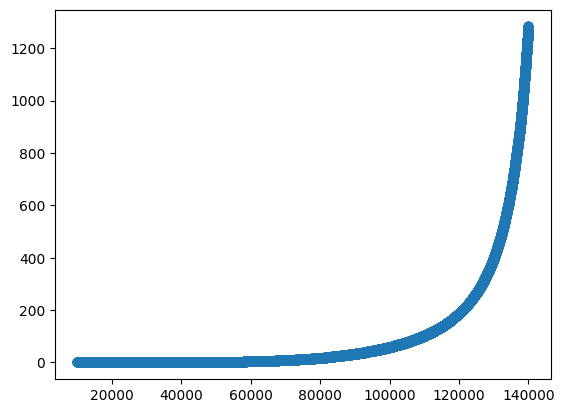

533.3955403831044 8773.982958504963
-85159.3 1788345.3


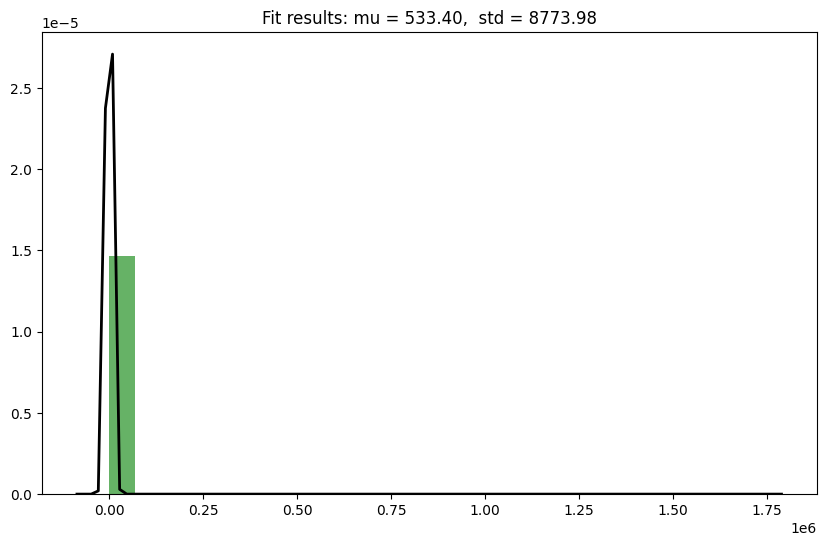

In [5]:
# make scatter plot of the new_df
# tmp_df is first 1000 rows of new_df
tmp_df = fnc_df[10000:140000]
plt.scatter(tmp_df.index, tmp_df)

plt.show()

# fit fnc_df to a normal distribution
from scipy.stats import norm
mu, std = norm.fit(fnc_df)
print(mu, std)

# plot the histogram of fnc_df
plt.figure(figsize=(10, 6))
plt.hist(fnc_df, bins=25, density=True, alpha=0.6, color='g')

# plot the PDF of the normal distribution
xmin, xmax = plt.xlim()
print(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
# plt.xlim(-1, 140000)
plt.show()


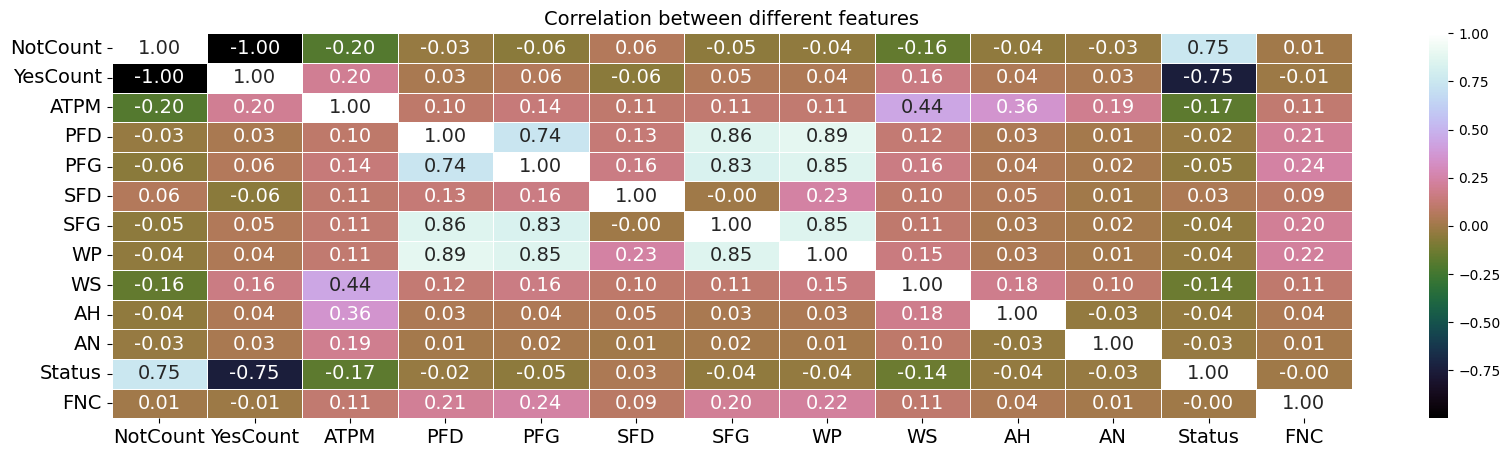

In [90]:
correlation_train = df.corr("pearson")
# plot correlation_train
fig = plt.figure(figsize=(20, 5))
sns.heatmap(correlation_train, vmax=1, annot=True, cmap='cubehelix', annot_kws={'size': 14}, fmt='.2f', linewidths=.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation between different features', fontsize=14)
plt.show()
plt.close()

In [7]:
class CostSensitiveLogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(CostSensitiveLogisticRegression, self).__init__()   
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.model(x)
        return out


    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            # self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            

            # Print training statistics 
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            
            train_losses.append(train_loss)

            # print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
        



In [8]:
cost_sensitive_log_model = CostSensitiveLogisticRegression(input_dim=X_train.shape[1])
return_val = cost_sensitive_log_model.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Cost Sensitive Logistic Regression Model: ", cost_sensitive_log_model.compute_expected_cost(test_loader))

Epoch: 1 	Training Loss: 20.712646 	Training Accuracy: 0.586531 	Validation Loss: 7.873089 	Validation Accuracy: 0.620631
Epoch: 2 	Training Loss: 7.433243 	Training Accuracy: 0.614776 	Validation Loss: 5.254777 	Validation Accuracy: 0.615111
Epoch: 3 	Training Loss: 5.486576 	Training Accuracy: 0.612050 	Validation Loss: 4.345847 	Validation Accuracy: 0.610065
Epoch: 4 	Training Loss: 4.645384 	Training Accuracy: 0.611889 	Validation Loss: 3.752374 	Validation Accuracy: 0.608947
Epoch: 5 	Training Loss: 4.176225 	Training Accuracy: 0.609273 	Validation Loss: 3.645745 	Validation Accuracy: 0.607830
Epoch: 6 	Training Loss: 3.924256 	Training Accuracy: 0.610644 	Validation Loss: 3.474065 	Validation Accuracy: 0.609794
Epoch: 7 	Training Loss: 3.714348 	Training Accuracy: 0.610382 	Validation Loss: 3.406941 	Validation Accuracy: 0.609760
Epoch: 8 	Training Loss: 3.579104 	Training Accuracy: 0.610323 	Validation Loss: 3.312884 	Validation Accuracy: 0.613756
Epoch: 9 	Training Loss: 3.4398

In [9]:
# Write class for normal logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        # Defining the number of input features
        self.input_dim = input_dim
        # Defining the number of output features
        self.output_dim = 1
        
        self.fc1 = nn.Linear(self.input_dim, 1)
        # Defining the sigmoid activation function
        self.sigmoid = nn.Sigmoid()
        # defining the loss crietion function
        self.loss_critetion = nn.BCELoss()
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # print('Batch: ', batch_idx)
                # print(data.shape)
                # print(target.shape)
                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

In [10]:
log_model = LogisticRegression(input_dim=X_train.shape[1])
return_val = log_model.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Logistic Regression Model: ", log_model.compute_expected_cost(test_loader))


Epoch: 1 	Training Loss: 0.373845 	Training Accuracy: 0.856775 	Validation Loss: 0.308574 	Validation Accuracy: 0.866195
Epoch: 2 	Training Loss: 0.307911 	Training Accuracy: 0.866224 	Validation Loss: 0.306876 	Validation Accuracy: 0.866296
Epoch: 3 	Training Loss: 0.307510 	Training Accuracy: 0.866199 	Validation Loss: 0.306699 	Validation Accuracy: 0.866263
Epoch: 4 	Training Loss: 0.307330 	Training Accuracy: 0.866097 	Validation Loss: 0.306740 	Validation Accuracy: 0.866635
Epoch: 5 	Training Loss: 0.307288 	Training Accuracy: 0.866275 	Validation Loss: 0.306496 	Validation Accuracy: 0.866127
Epoch: 6 	Training Loss: 0.307224 	Training Accuracy: 0.866182 	Validation Loss: 0.306407 	Validation Accuracy: 0.865992
Epoch: 7 	Training Loss: 0.307181 	Training Accuracy: 0.866317 	Validation Loss: 0.306366 	Validation Accuracy: 0.866296
Epoch: 8 	Training Loss: 0.307123 	Training Accuracy: 0.866089 	Validation Loss: 0.306320 	Validation Accuracy: 0.865992
Epoch: 9 	Training Loss: 0.30709

In [13]:
# Class for Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(NeuralNetwork, self).__init__()
        # Defining the number of input nodes, hidden nodes and output nodes
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = 1
        # Defining the layers
        self.fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.output_dim)
        self.loss_critetion = nn.BCELoss()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Forward pass through the network
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss

    def compute_expected_cost(self, test_loader):
        self.eval()
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.loss_critetion
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # print('Batch: ', batch_idx)
                # print(data.shape)
                # print(target.shape)
                target = target[:, 0].view(-1, 1)
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
    
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            train_losses.append(train_loss)
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
        
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
            
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
            
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
    

In [15]:
neural_network_model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = neural_network_model.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of NN Model: ", neural_network_model.compute_expected_cost(test_loader))

Epoch: 1 	Training Loss: 0.321083 	Training Accuracy: 0.860619 	Validation Loss: 0.299961 	Validation Accuracy: 0.865450
Epoch: 2 	Training Loss: 0.298370 	Training Accuracy: 0.866368 	Validation Loss: 0.295799 	Validation Accuracy: 0.866771
Epoch: 3 	Training Loss: 0.295279 	Training Accuracy: 0.866851 	Validation Loss: 0.294174 	Validation Accuracy: 0.866330
Epoch: 4 	Training Loss: 0.293107 	Training Accuracy: 0.866978 	Validation Loss: 0.292027 	Validation Accuracy: 0.867414
Epoch: 5 	Training Loss: 0.291653 	Training Accuracy: 0.867418 	Validation Loss: 0.290543 	Validation Accuracy: 0.866229
Epoch: 6 	Training Loss: 0.290426 	Training Accuracy: 0.867359 	Validation Loss: 0.289798 	Validation Accuracy: 0.866635
Epoch: 7 	Training Loss: 0.289734 	Training Accuracy: 0.867054 	Validation Loss: 0.289496 	Validation Accuracy: 0.867346
Epoch: 8 	Training Loss: 0.288948 	Training Accuracy: 0.867562 	Validation Loss: 0.288694 	Validation Accuracy: 0.866804
Epoch: 9 	Training Loss: 0.28848

In [16]:
# Cost Sensitive Neural Network Model
class CostSensitiveNeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CostSensitiveNeuralNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.loss_critetion = self.compute_loss
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def compute_loss(self, y_pred, y_true, false_negative_cost):
        epsilon = 1e-7
        true_positive_cost = 4.0
        false_positive_cost = 4.0
        true_negative_cost = 0
        # print("False Negative Cost: ",false_negative_cost.reshape(-1,1).shape)
        
        # print("Y_pred Shape: ",y_pred.shape)
        # print("Y_true Shape: ",y_true.shape)

        # Compute the losses for true positives, false positives, true negatives, and false negatives
        # tp_loss = y_true * torch.log(y_pred + epsilon) * true_positive_cost
        # fp_loss = y_true * torch.log(1 - y_pred + epsilon) * false_positive_cost
        # tn_loss = (1 - y_true) * torch.log(1 - y_pred + epsilon) * true_negative_cost
        # fn_loss = (1 - y_true) * torch.log(y_pred + epsilon) * false_negative_cost
        
        tp_loss = y_true * y_pred * true_positive_cost
        fp_loss = (1 - y_true) * y_pred * false_positive_cost
        fn_loss = (y_true * (1 - y_pred)) * false_negative_cost.reshape(-1,1)
        # tn_loss = (1 - y_true) * (1 - y_pred) * true_negative_cost
        tn_loss = torch.multiply((1 - y_true), (1 - y_pred)) * true_negative_cost
        # print((1-y_true).shape)
        # print((1-y_pred).shape)

        # Compute the total loss
        # total_loss = y_true * (y_pred * true_positive_cost + (1 - y_pred) * false_negative_cost) + (1 - y_true) * (y_pred * false_positive_cost + (1 - y_pred) * true_negative_cost)

        # total_loss = total_loss.mean()
        total_loss = tp_loss + fp_loss + tn_loss + fn_loss
        # print(tp_loss.shape, fp_loss.shape, tn_loss.shape, fn_loss.shape)
        # print("Loss Shape: ",total_loss.shape)
        total_loss = total_loss.mean()

        return total_loss
    
    def compute_expected_cost(self, test_loader):
        # compute the expected cost for the test data
        total_cost = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = self(data)
            false_neg_cost = target[:, 1]
            target = target[:, 0].view(-1, 1)
            loss = self.compute_loss(output, target, false_neg_cost)
            total_cost += loss.item() * data.size(0)
        return total_cost
    
    def train_model(self, train_loader, test_loader, num_epochs, learning_rate):
        # Define the loss function and the optimizer
        criterion = self.compute_loss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.train()

        # Lists to keep track of progress
        train_losses = []
        test_losses = []
        test_accuracies = []
        train_accuracies = []
        best_accuracy = 0
        best_model = None

        # Number of epochs
        n_epochs = num_epochs

        for epoch in range(n_epochs):
            # Monitor training loss
            train_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.train()
            # self.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Clear the gradients of all optimized variables
                optimizer.zero_grad()
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Backward pass: compute gradient of the loss with respect to model parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Update running training loss
                train_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)               
            

            # Print training statistics 
            # Calculate average loss over an epoch
            train_loss = train_loss / len(train_loader.dataset)
            
            # Calculate training accuracy
            train_accuracy = correct_classified / total_classified
        
            # Append to the training loss and accuracy lists
            train_accuracies.append(train_accuracy)
            
            train_losses.append(train_loss)

            # print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy))
        
            # Test the model for validation
            test_loss = 0.0
            total_classified = 0
            correct_classified = 0
            self.eval()
            for batch_idx, (data, target) in enumerate(test_loader):
                # Forward pass: compute predicted outputs by passing inputs to the model
                output = self(data)
                false_neg_cost = target[:, 1]
                target = target[:, 0].view(-1, 1)
                # Calculate the batch loss
                loss = criterion(output, target, false_neg_cost)
                # Update running validation loss 
                test_loss += loss.item() * data.size(0)
                # Calculate the number of correct classifications
                pred = output >= 0.5
                correct_classified += (pred == target).sum().item()
                total_classified += len(target)
        
            # Calculate average loss over an epoch
            test_loss = test_loss / len(test_loader.dataset)
        
            # Calculate validation accuracy
            test_accuracy = correct_classified / total_classified
            
            # Append to the validation loss and accuracy lists
            test_accuracies.append(test_accuracy)
            test_losses.append(test_loss)
        
            # print both test and train loss and accuracy
            print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, train_accuracy, test_loss, test_accuracy))
        
            if test_accuracy > best_accuracy:
                best_accuracy = test_accuracy
                # best_model = self.state_dict()
                # torch.save(best_model, 'best_model.pt')
                torch.save(self.state_dict(), 'best_model.pt')
                
        # print('Best Accuracy: ', best_accuracy)
        # Load the best model
        self.load_state_dict(torch.load('best_model.pt'))
        return train_losses, test_losses, train_accuracies, test_accuracies, best_accuracy, best_model
        

In [17]:
cost_sensitive_nn = CostSensitiveNeuralNetwork(input_dim=X_train.shape[1], hidden_dim=20)
return_val = cost_sensitive_nn.train_model(train_loader, test_loader, num_epochs=10, learning_rate=0.001)
print("Cost of Cost Sensitive Neural Network: ", cost_sensitive_nn.compute_expected_cost(test_loader))

Epoch: 1 	Training Loss: 6.486117 	Training Accuracy: 0.583855 	Validation Loss: 2.736416 	Validation Accuracy: 0.659476
Epoch: 2 	Training Loss: 2.860453 	Training Accuracy: 0.660345 	Validation Loss: 2.632052 	Validation Accuracy: 0.658629
Epoch: 3 	Training Loss: 2.669326 	Training Accuracy: 0.661115 	Validation Loss: 2.605027 	Validation Accuracy: 0.662016
Epoch: 4 	Training Loss: 2.613472 	Training Accuracy: 0.663427 	Validation Loss: 2.584661 	Validation Accuracy: 0.663269
Epoch: 5 	Training Loss: 2.718222 	Training Accuracy: 0.667474 	Validation Loss: 2.569770 	Validation Accuracy: 0.668789
Epoch: 6 	Training Loss: 3.701544 	Training Accuracy: 0.676245 	Validation Loss: 2.565139 	Validation Accuracy: 0.679050
Epoch: 7 	Training Loss: 2.602068 	Training Accuracy: 0.681537 	Validation Loss: 2.524498 	Validation Accuracy: 0.685620
Epoch: 8 	Training Loss: 3.159275 	Training Accuracy: 0.687362 	Validation Loss: 2.554529 	Validation Accuracy: 0.678542
Epoch: 9 	Training Loss: 2.53946